# Examples of using the various functions in `Utils`

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from polartoolkit import fetch, maps, regions, utils

## Coordinate conversions and formats

Converting GMT region strings between meters in EPSG:3031 and lat long 

In [2]:
pig = regions.pine_island_glacier

pig_latlon = utils.region_xy_to_ll(pig)

print(pig)
print(pig_latlon)

(-1720000.0, -1480000.0, -380000.0, -70000.0)
(-104.40002130679105, -92.33051886797894, -76.42465660818513, -73.8906485263336)


Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use officia

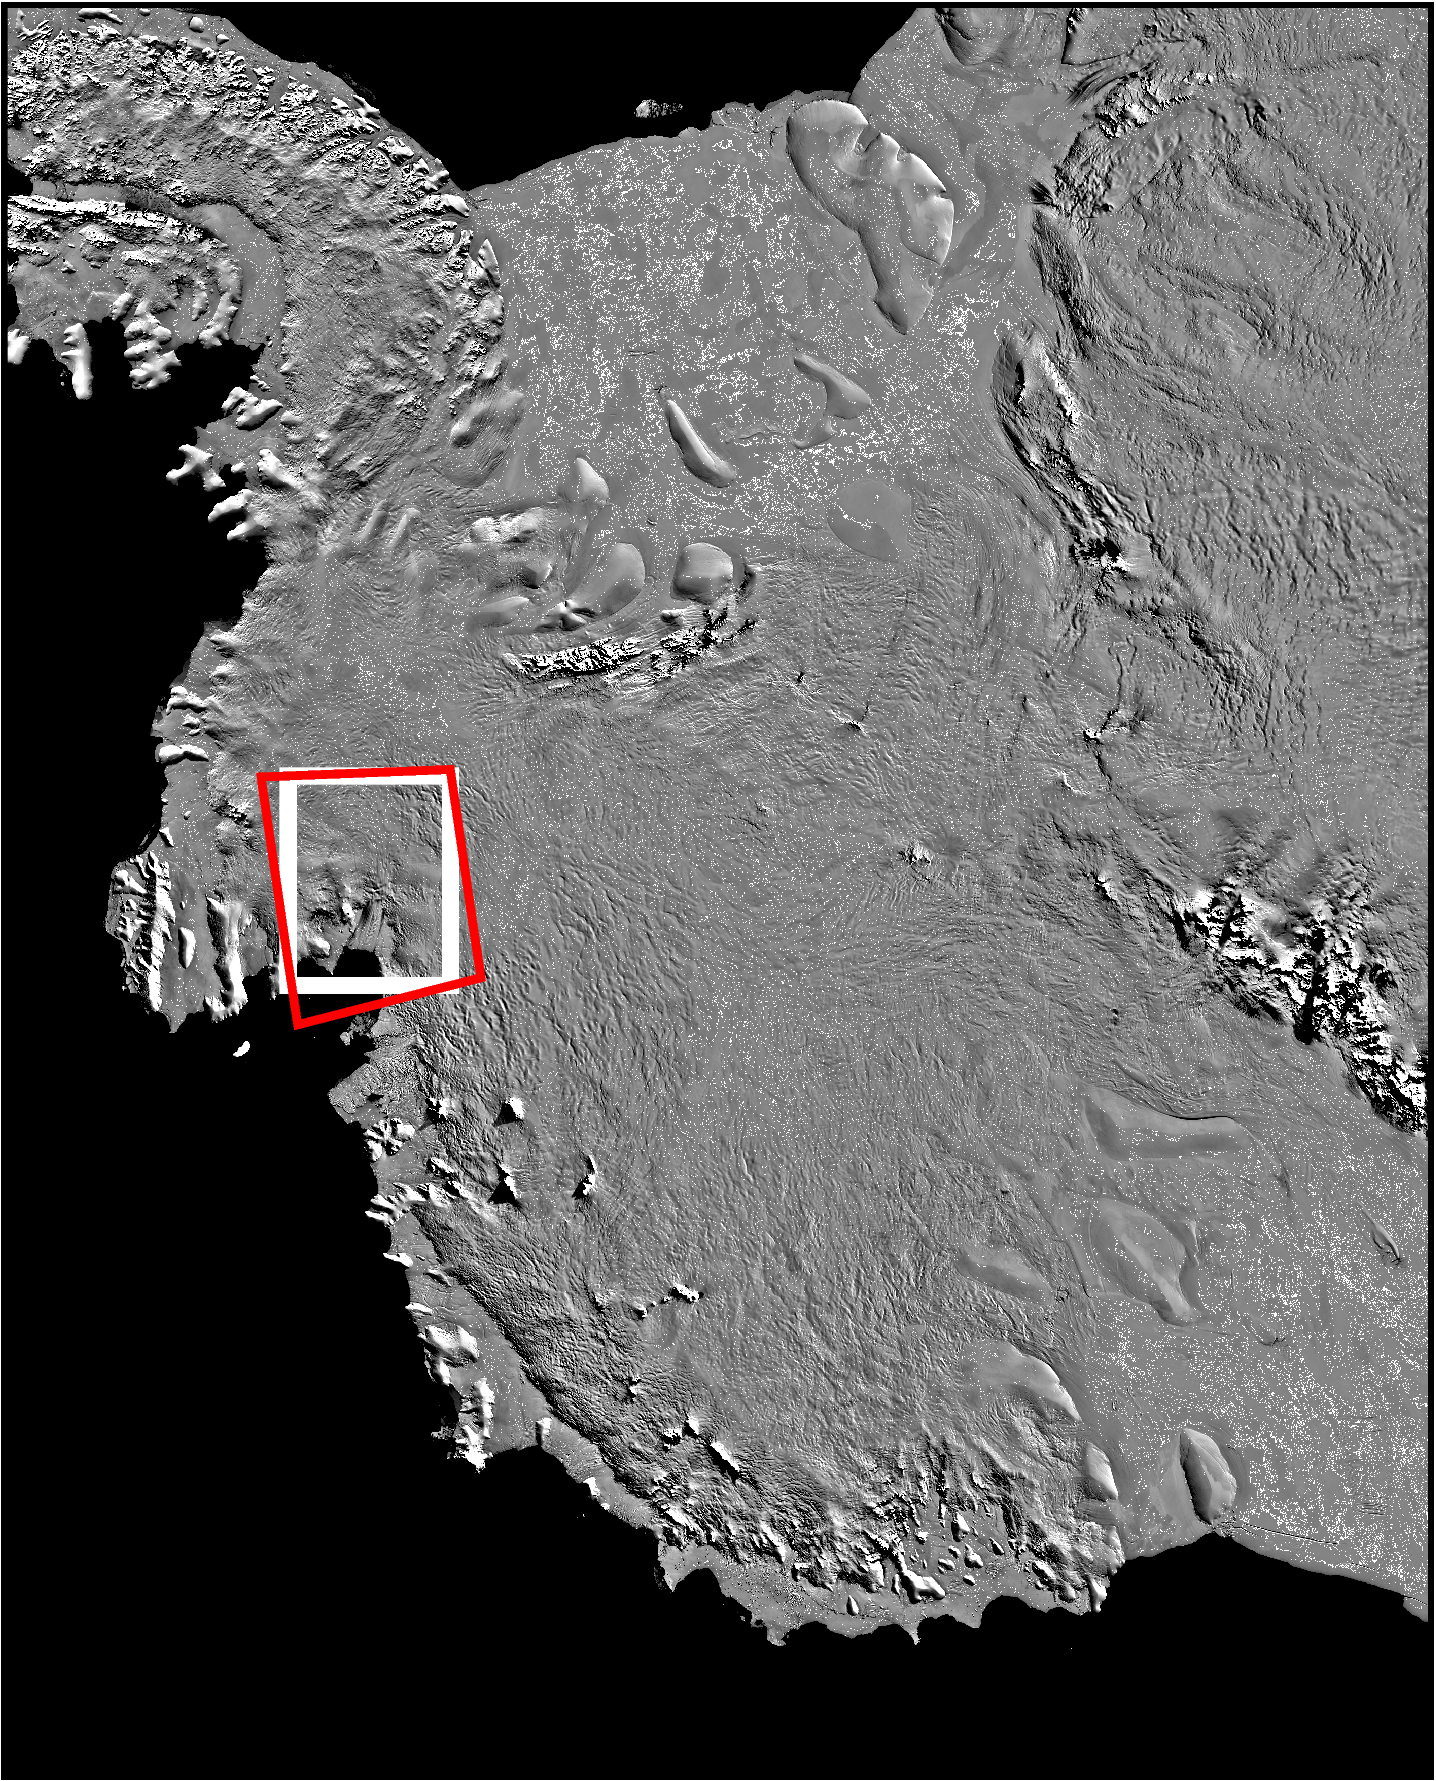

In [4]:
figure_region = utils.alter_region(regions.west_antarctica, zoom=600e3)[0]

fig = maps.plot_grd(
    fetch.modis_moa(),
    image=True,
    cmap="gray",
    region=figure_region,
)

fig.plot(
    x=[pig[0], pig[0], pig[1], pig[1], pig[0]],
    y=[pig[2], pig[3], pig[3], pig[2], pig[2]],
    pen="4p,white",
)


fig.plot(
    projection=utils.set_proj(figure_region)[1],
    region=utils.gmt_str_to_list(figure_region)+"+ue",
    x=[pig_latlon[0], pig_latlon[0], pig_latlon[1], pig_latlon[1], pig_latlon[0]],
    y=[pig_latlon[2], pig_latlon[3], pig_latlon[3], pig_latlon[2], pig_latlon[2]],
    pen="2p,red",
)

fig.show()

### Converting from GMT region strings to other formats

In [5]:
# To use the boundingbox format used in IcePyx:

# region in meters in format [e, w, n, s]
lis = regions.larsen_ice_shelf
print(lis)

# convert to decimal degress
lis_latlon = utils.region_xy_to_ll(lis)
print(lis_latlon)

# switch order to [lower left lat, upper right long, uper right lat]
lis_bb = utils.region_to_bounding_box(lis_latlon)
print(lis_bb)

(-2430000.0, -1920000.0, 900000.0, 1400000.0)
(-69.67686317033707, -53.901716032892004, -70.66216685997603, -64.59654842562178)
(-69.67686317033707, -70.66216685997603, -53.901716032892004, -64.59654842562178)


### Convert between EPSG:3031 and WGS84 lat/lon

In [6]:
# get coordinates for center of Roosevelt Island
RI = regions.roosevelt_island
RI_center = [((RI[0] + RI[1]) / 2), ((RI[2] + RI[3]) / 2)]
RI_center

[-360000.0, -1100000.0]

In [7]:
# convert to lat lon
RI_center_latlon = utils.epsg3031_to_latlon(RI_center)
print(RI_center_latlon)

# convert back to epsg 3031
epsg = utils.latlon_to_epsg3031(RI_center_latlon)
epsg

[-79.37689147851952, -161.87813975209863]


[-360000.0000000289, -1100000.0000000878]

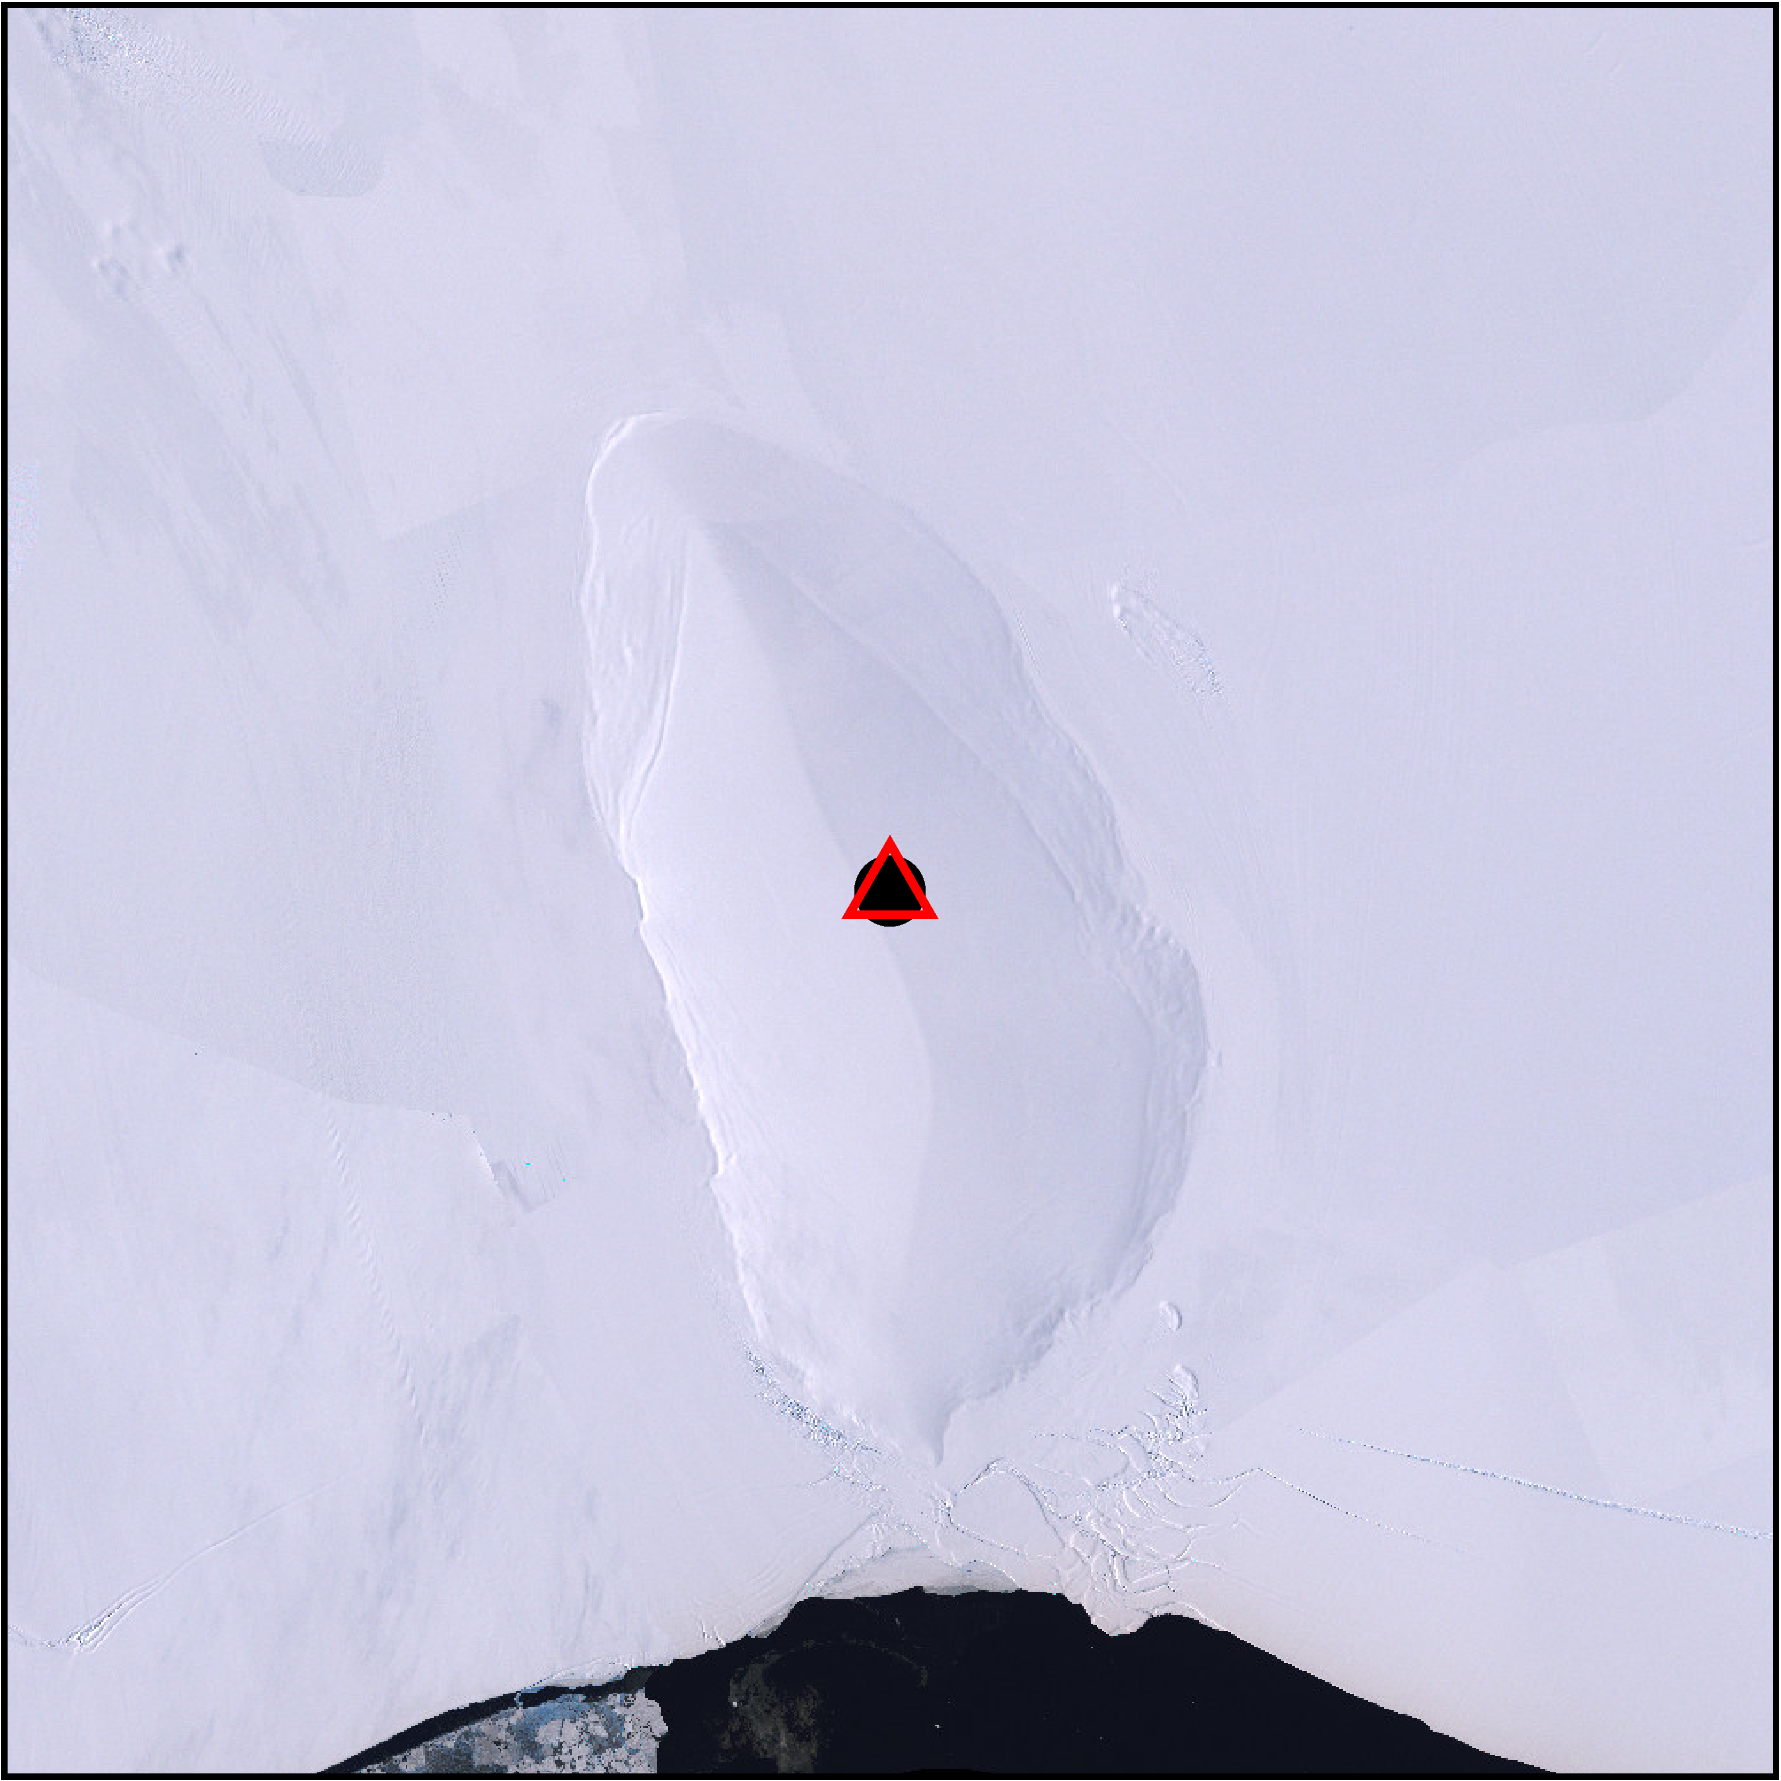

In [12]:
# plot on map
fig = maps.plot_grd(
    fetch.imagery(),
    region=regions.roosevelt_island,
    image=True,
)

fig.plot(
    x=RI_center[0],
    y=RI_center[1],
    style="c.6c",
    fill="black",
)
fig.plot(
    x=RI_center_latlon[1],
    y=RI_center_latlon[0],
    region=regions.roosevelt_island+("+ue",),
    projection=utils.set_proj(regions.roosevelt_island)[1],
    style="t.8c",
    pen="2p,red",
)
fig.show()

## Grid processes

### Fit a trend to a grid and optionally remove it

/home/mdtanker/miniforge3/envs/polartoolkit/lib/python3.11/site-packages/verde/base/least_squares.py:68: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  regr.fit(jacobian, data.ravel(), sample_weight=weights)


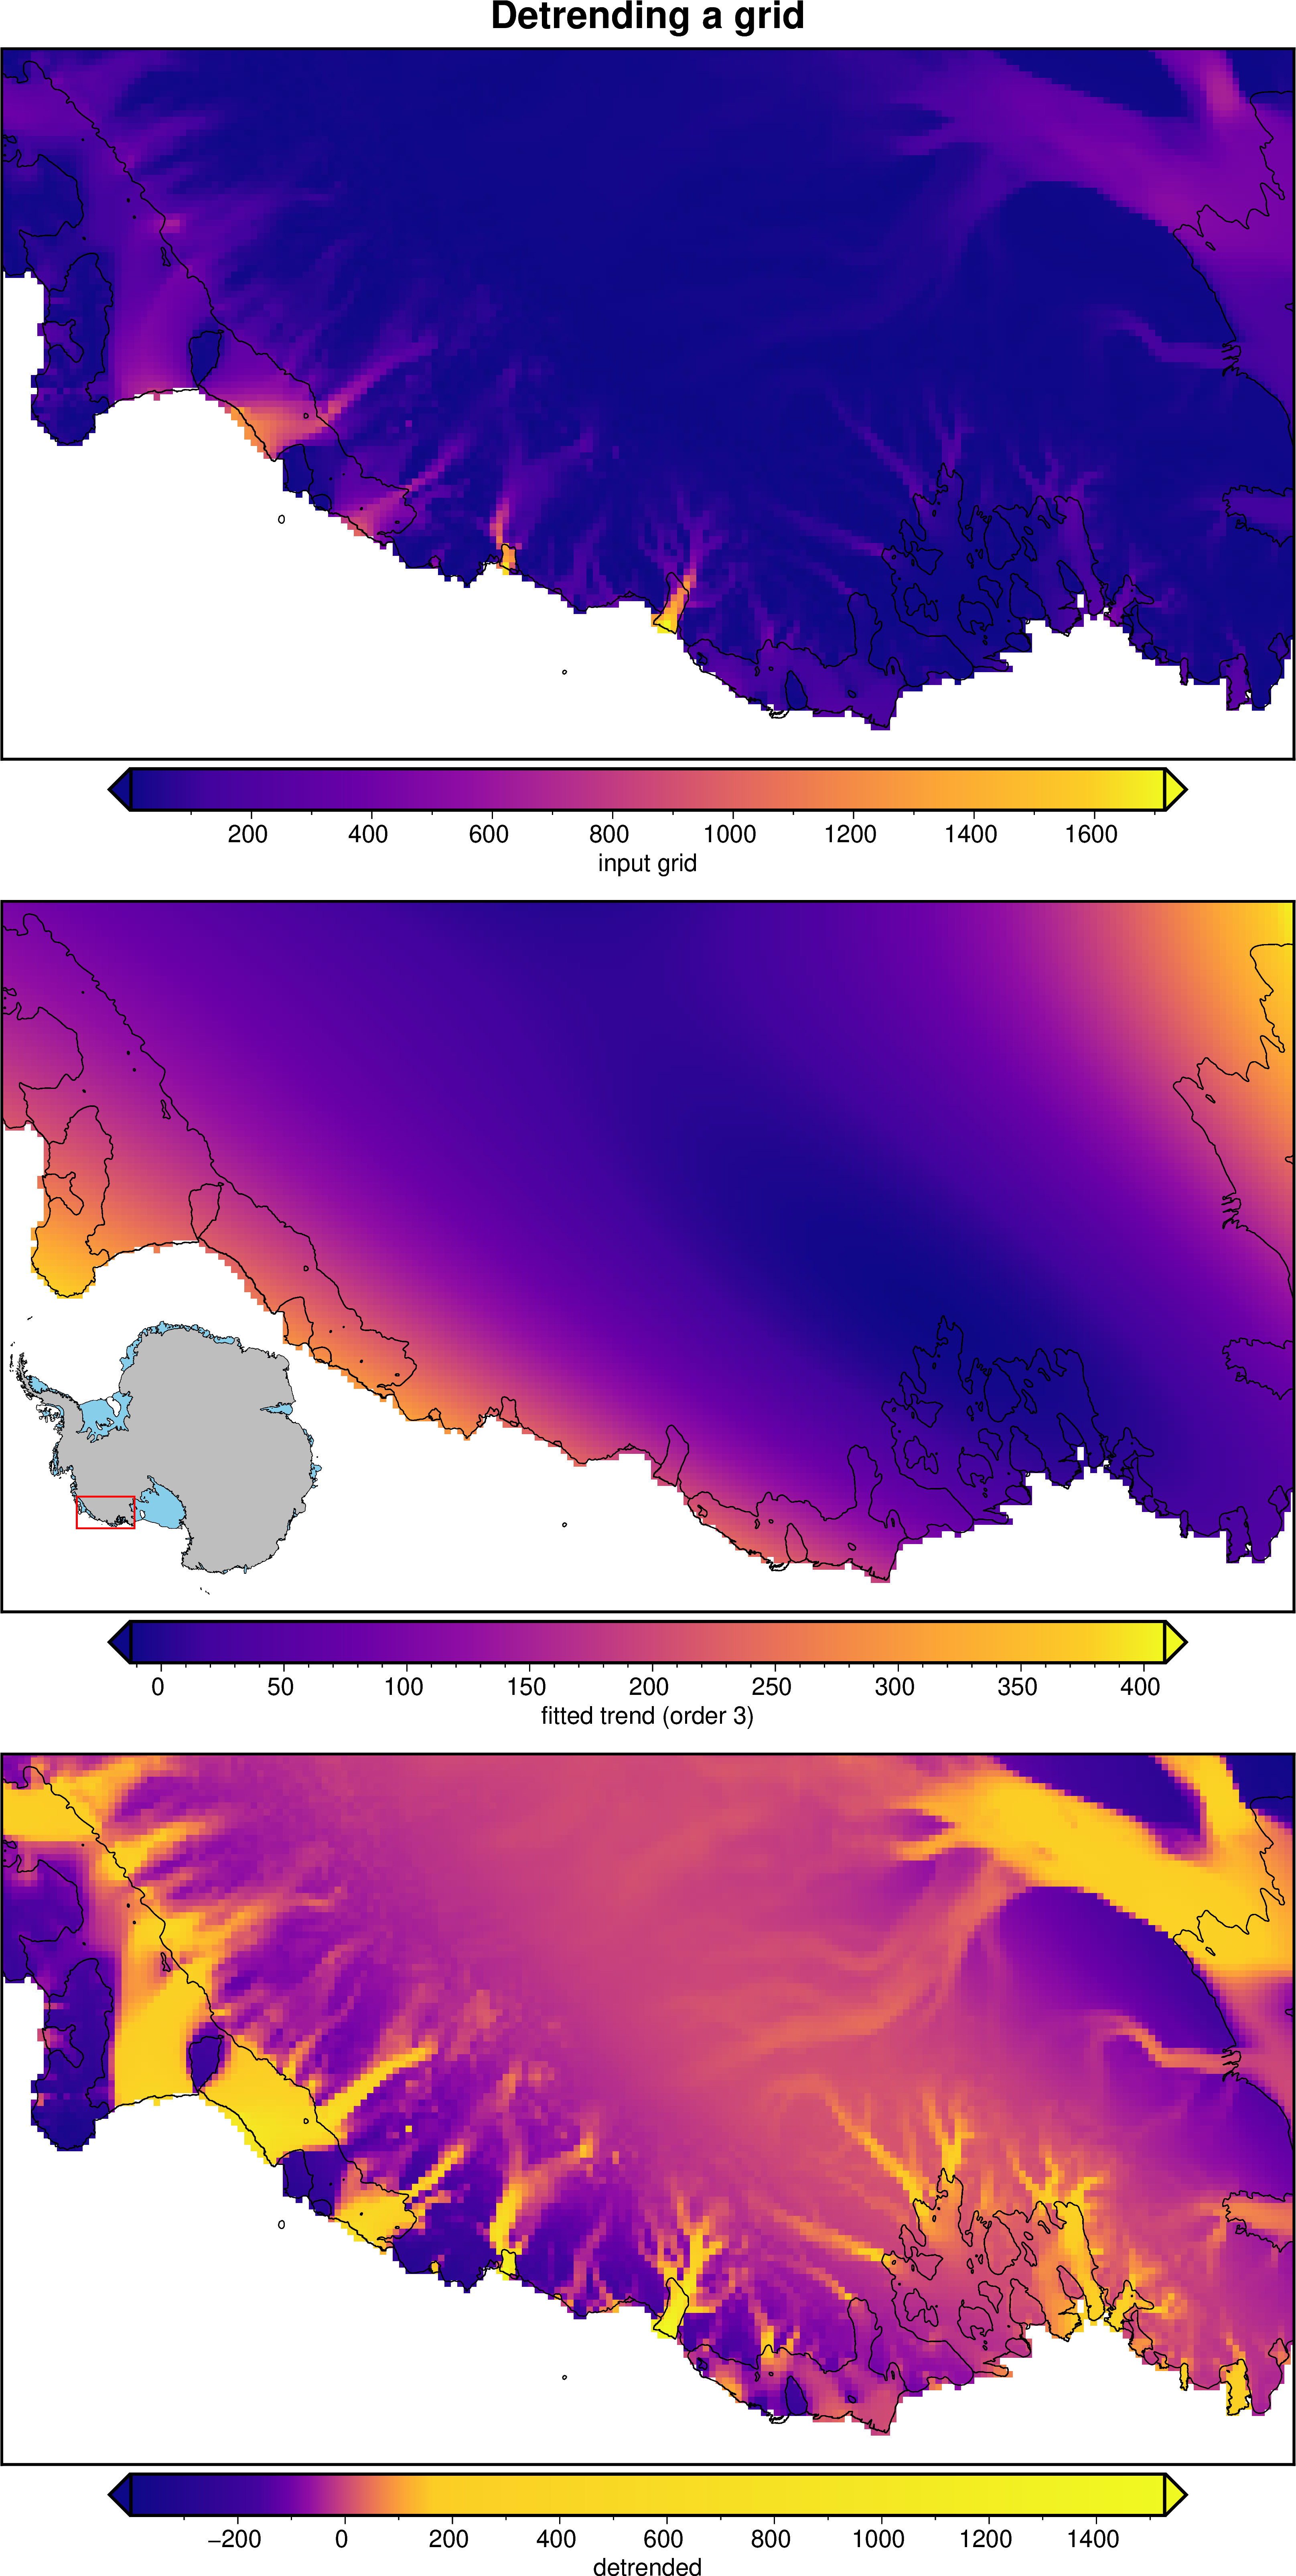

In [14]:
# download
ice_velocity = fetch.ice_vel(
    region=regions.marie_byrd_land,
    spacing=5e3,
)

# extract and detrend
fit, detrend = utils.grd_trend(ice_velocity, deg=3, plot=True)

### compare two different grids

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


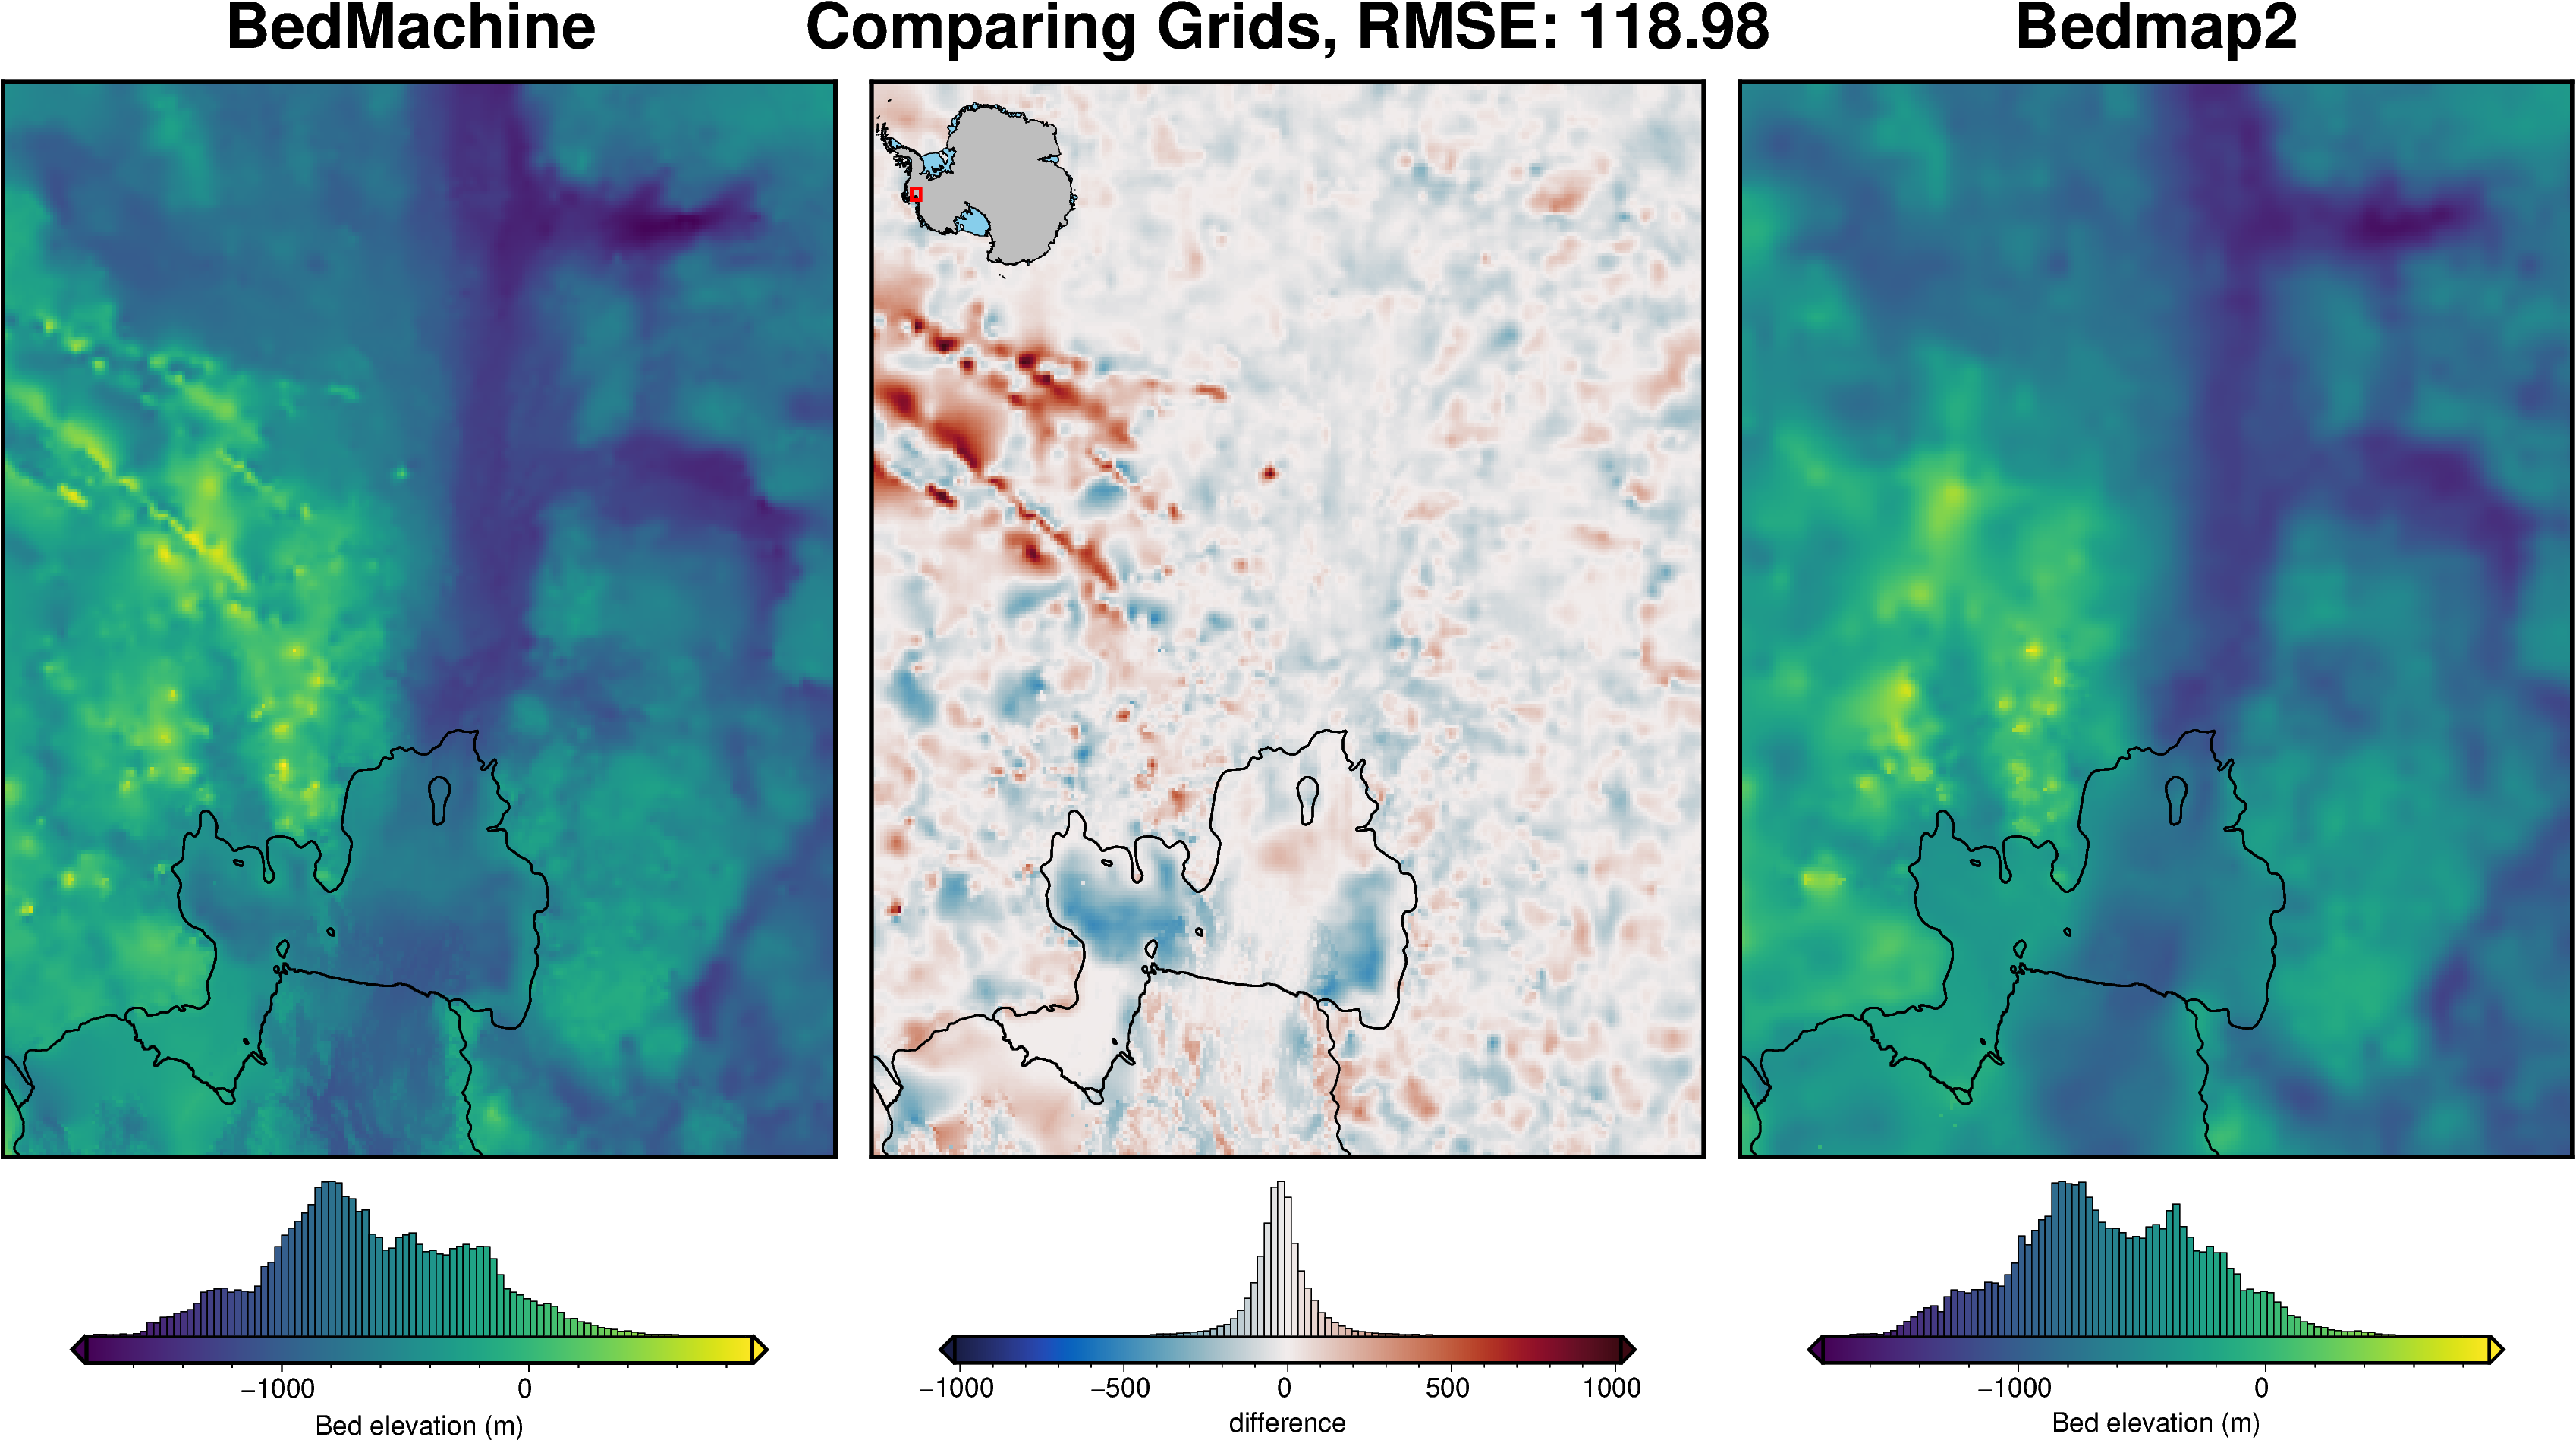

In [15]:
# define a region of interest
region = regions.pine_island_glacier

# load the 2 grids to compare, at 1km resolution
bedmachine = fetch.bedmachine(
    layer="bed",
    spacing=1e3,
    region=region,
)
bedmap = fetch.bedmap2(
    layer="bed",
    spacing=1e3,
    region=region,
)

# run the difference function and plot the results
dif, grid1, grid2 = utils.grd_compare(
    bedmachine,
    bedmap,
    plot=True,
    coast=True,
    grid1_name="BedMachine ",
    grid2_name="Bedmap2",
    cbar_label="Bed elevation (m)",
    hist=True,
)

Lets say we're only interested in the region under the ice shelf (the closed black polygon). Higher or lower values outside of the ice shelf are skewing the color ramp. We can use a regional mask to set the colorscale's max and min values based on a shapefile. We'll define a shapefile for the island, and re-run the above code with the kwarg `shp_mask`.

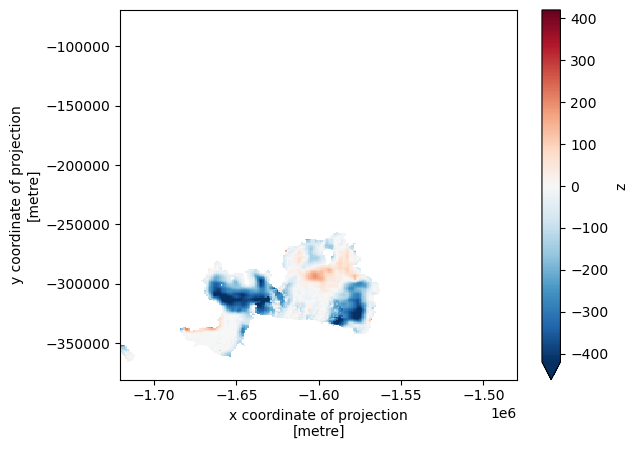

In [16]:
# load the grounding and coast line database
import pyogrio

shp = pyogrio.read_dataframe(fetch.groundingline())

# subset only the ice shelf region for the mask. See the Fetch Walkthrough for the
# groundingline ID classifications
shp_mask = shp[shp.Id_text == "Ice shelf"]

# view the mask area:
utils.mask_from_shp(shp_mask, xr_grid=dif, masked=True, invert=False).plot(robust=True)

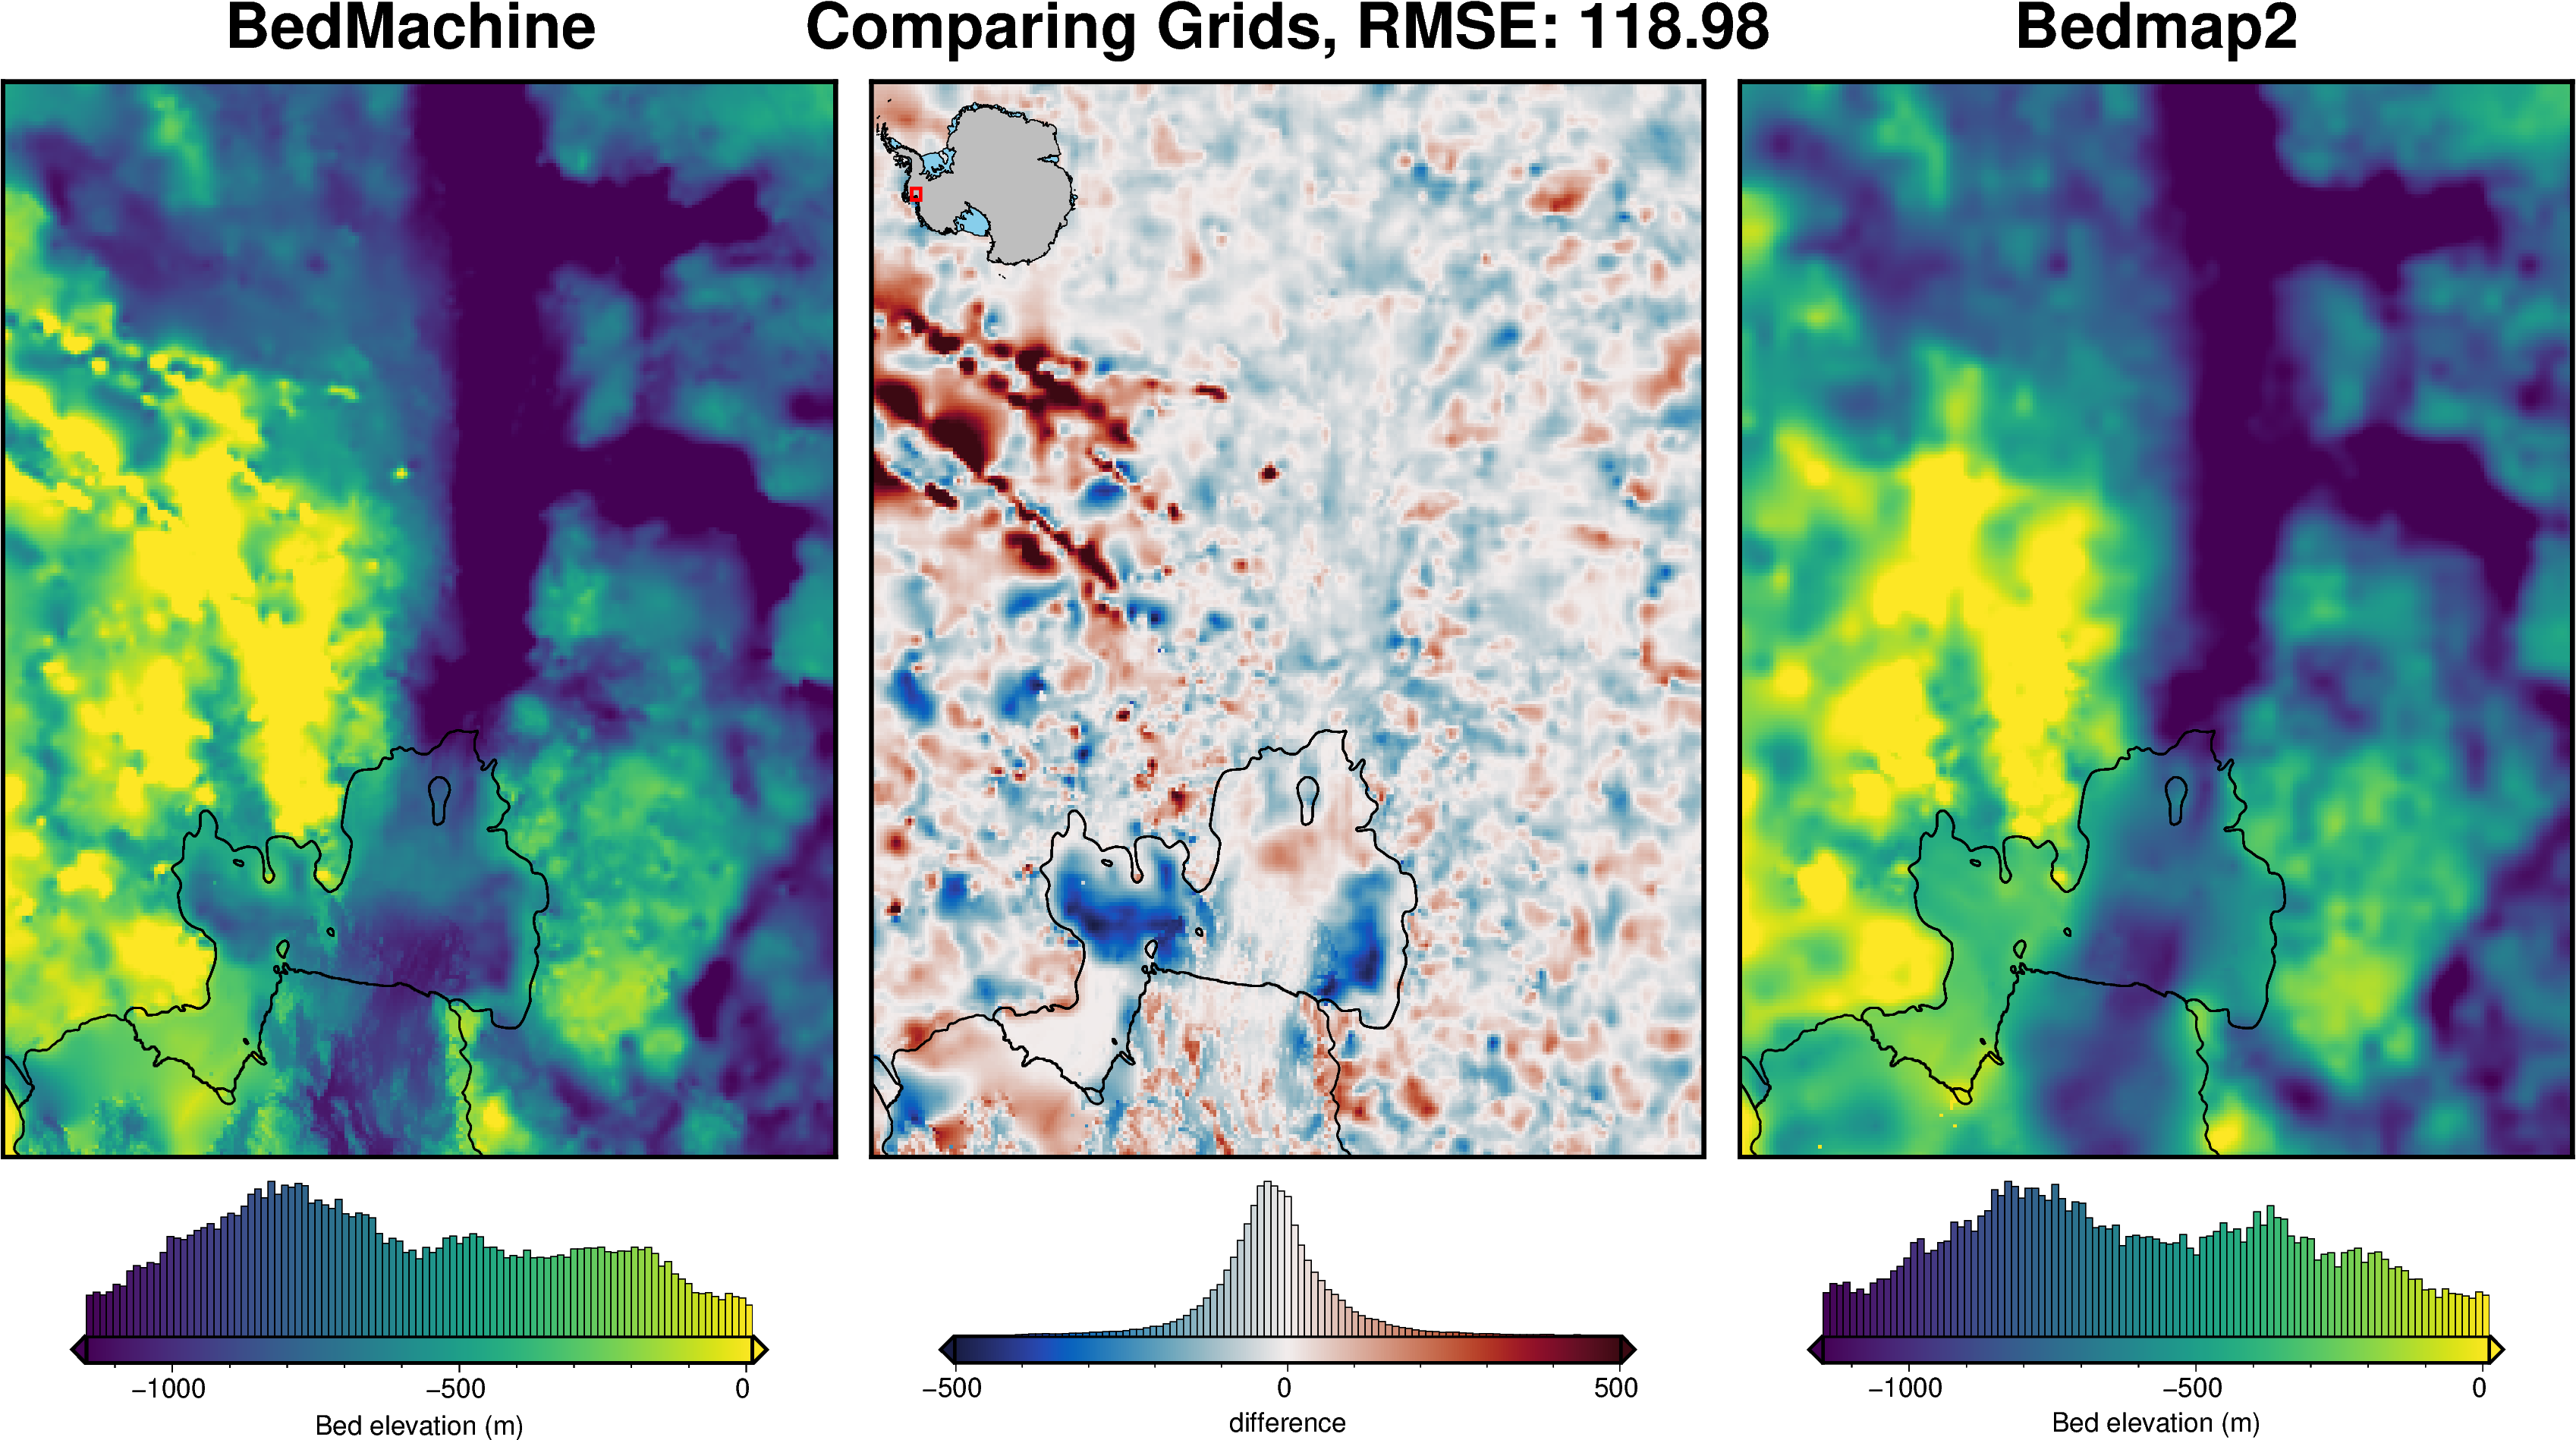

In [17]:
# re-run the difference function.
# note how the color scale are now set to just the sub-ice-shelf regions.
dif, grid1, grid2 = utils.grd_compare(
    bedmachine,
    bedmap,
    plot=True,
    coast=True,
    grid1_name="BedMachine ",
    grid2_name="Bedmap2",
    cbar_label="Bed elevation (m)",
    hist=True,
    shp_mask=shp_mask,
)

### Interactively mask a grid

In [23]:
polygon = regions.draw_region(
    points=utils.region_to_df(region),  # plot corners of region
)

Label(value='')

Map(center=[-75.1282216924775, -97.58308196293555], controls=(ZoomControl(options=['position', 'zoom_in_text',…

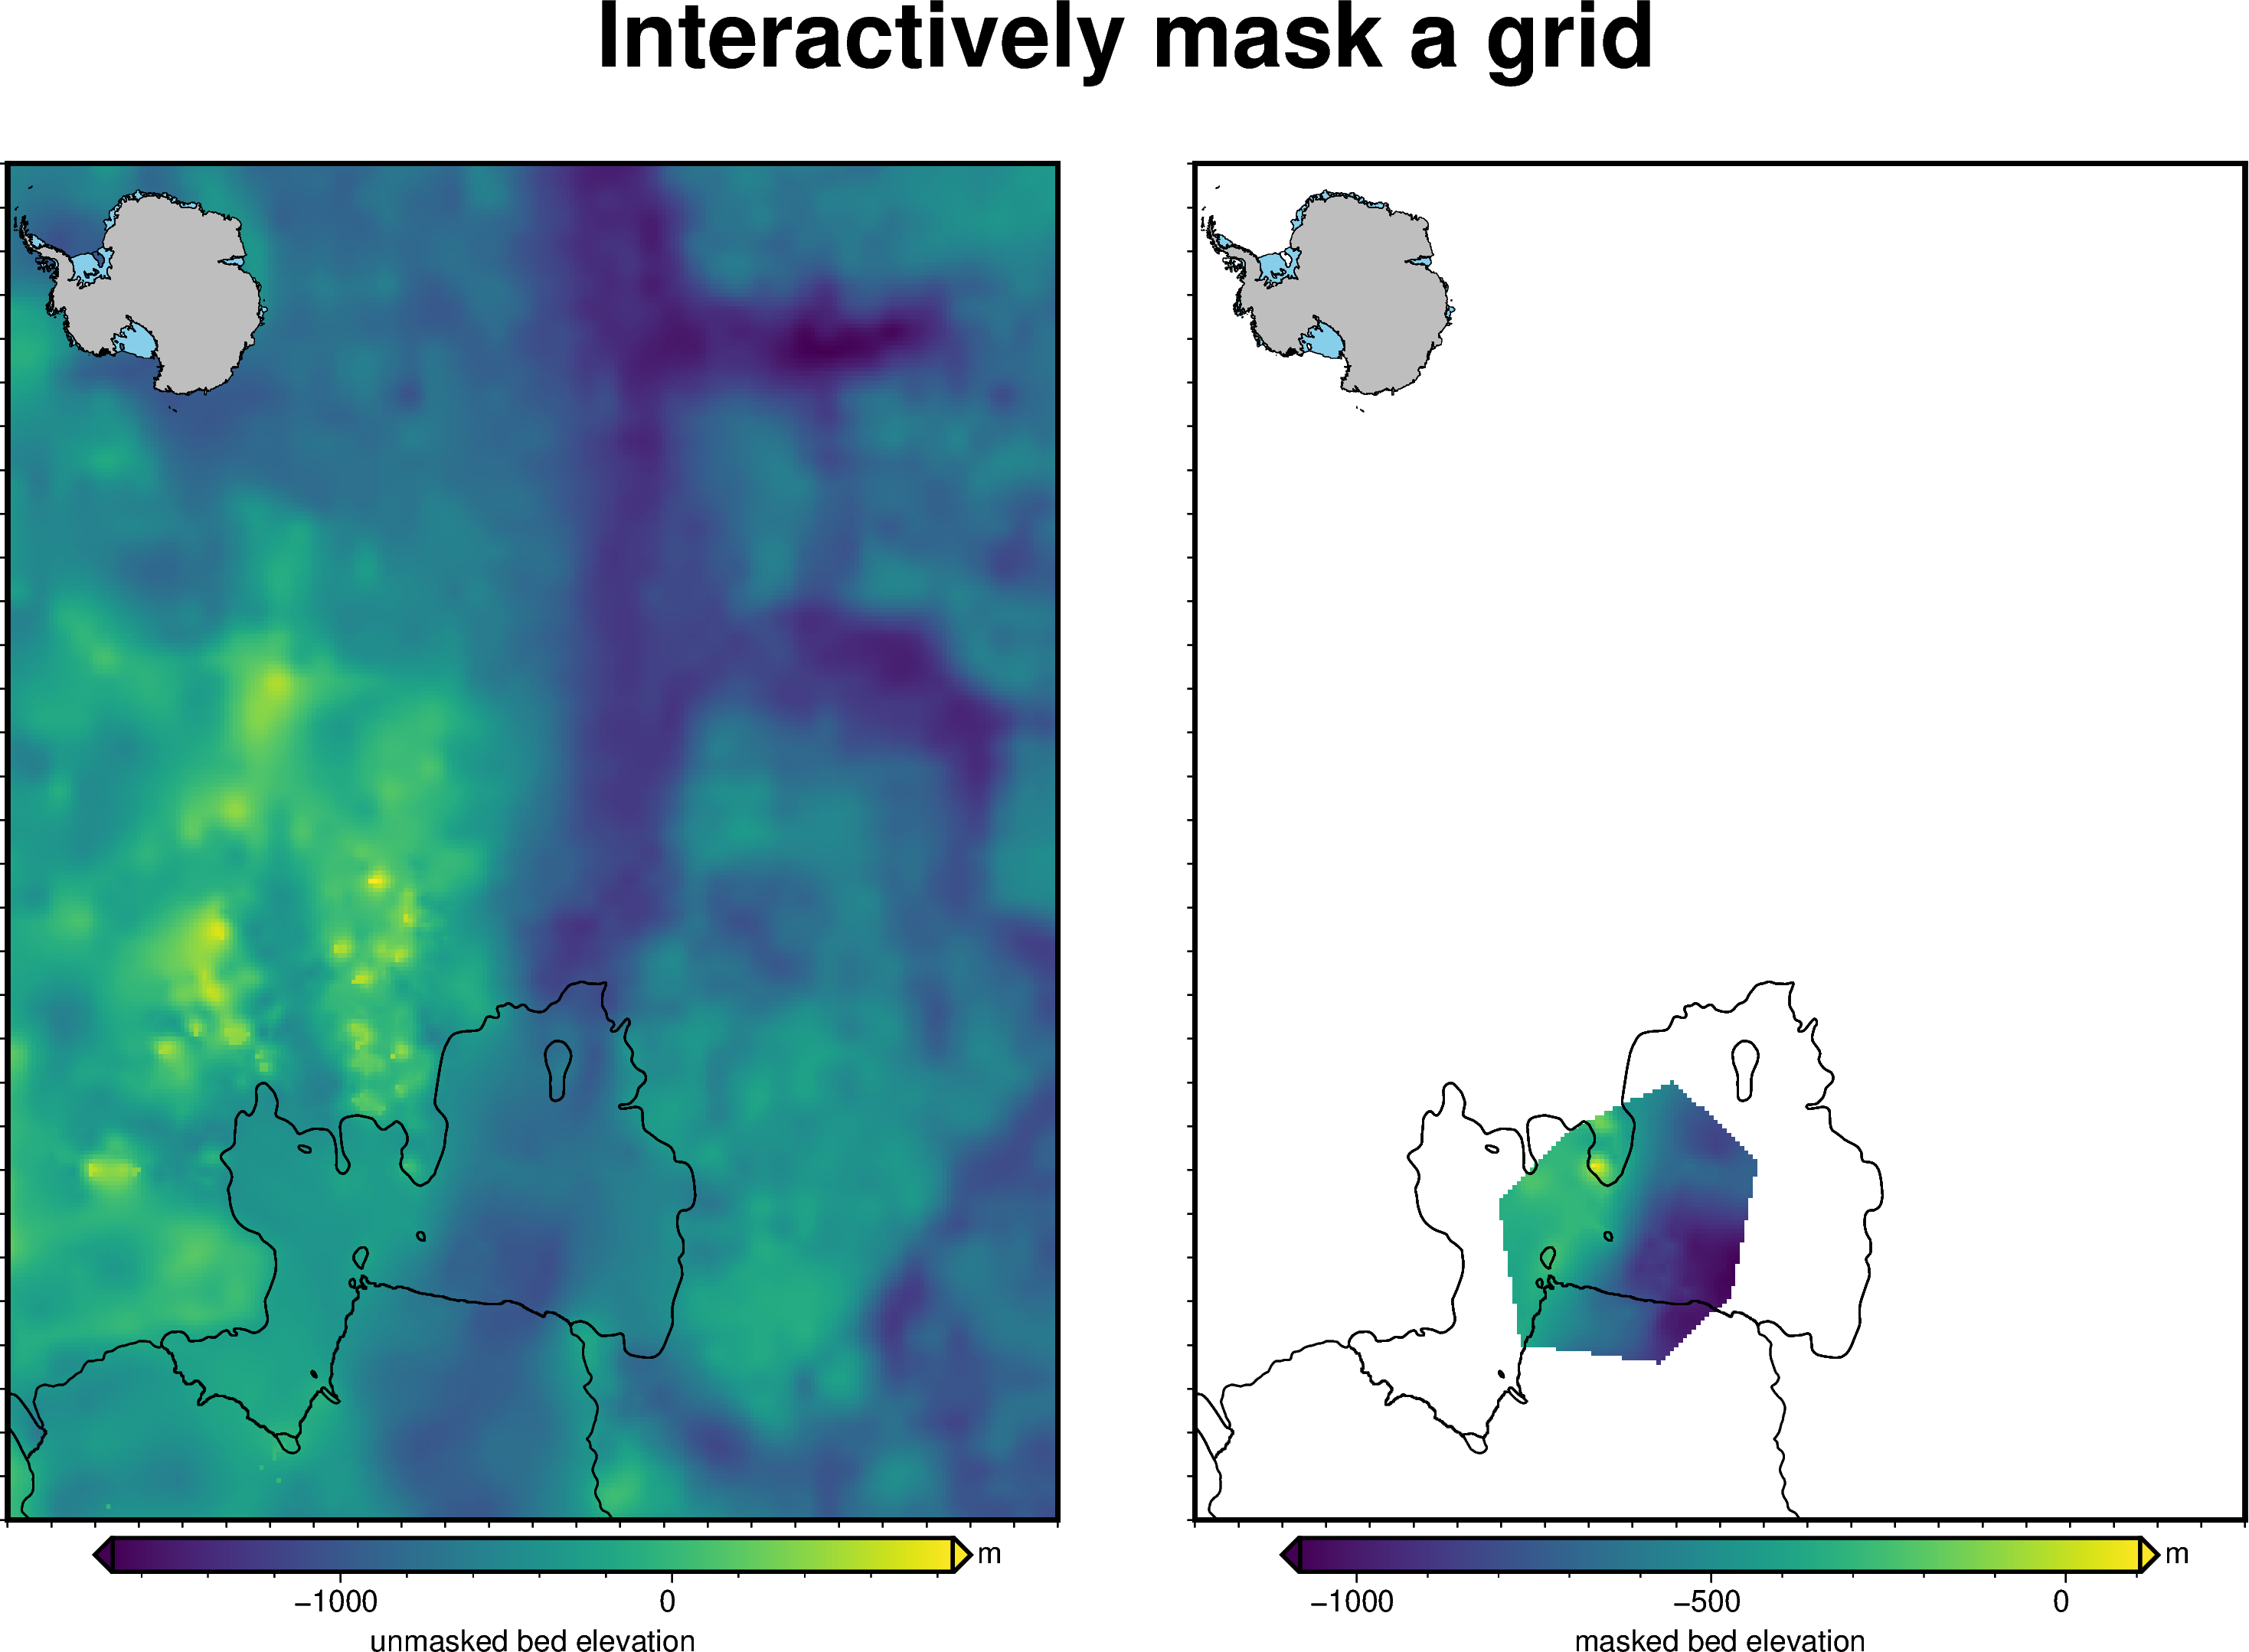

In [24]:
masked = utils.mask_from_polygon(polygon, grid=bedmap)

# show results in a plot
fig = maps.subplots(
    [bedmap, masked],
    region=regions.pine_island_glacier,
    coast=True,
    inset=True,
    fig_title="Interactively mask a grid",
    cbar_labels=["unmasked bed elevation", "masked bed elevation"],
    cbar_units=["m", "m"],
)

fig.show()

### radially averaged power spectrum

In [25]:
# coming soon

### coherency between 2 grids

In [26]:
# coming soon